# Importing libs

In [2]:
import cv2 as cv
import shutil
import pandas as pd 

from pathlib import Path
from glob import glob

from tqdm import tqdm

import os

# Importing data

In [11]:
df = Path('/kaggle/input/wiki-faces/wiki_crop')
dest = Path('/kaggle/working/wiki_crop_all')
dest.mkdir(exist_ok=True)

folders = [folder for folder in glob(str(df / '*')) if Path(folder).is_dir()]

files = []
for folder in tqdm(folders, unit='folder', desc='Copying folders content to dest folder...'):
    folder_files = glob(str(Path(folder) / '*'))
    files.extend(folder_files)

    shutil.copytree(folder, dest, dirs_exist_ok=True)

assert len(files) == len(files)

Copying folders content to dest folder...: 100%|██████████| 100/100 [02:48<00:00,  1.69s/folder]


# Detect faces

In [47]:
# Load images folder
files = os.listdir('/kaggle/working/wiki_crop_all')
image_files = [file for file in files]
detected_faces = []

In [39]:
# Load the classifier and create a cascade object for face detection
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_alt.xml')

In [ ]:
# Iterate through images
for image in tqdm(image_files, unit='image', desc='Processing images...'):
    # Open original image
    original_image = cv.imread('/kaggle/working/wiki_crop_all/' + image)
    
    if original_image is None:
            print(f"Error: Failed to read image '{image}'. Skipping...")
            continue
            
    # Gray scale image
    grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
    # Get cords of face
    detected_face = face_cascade.detectMultiScale(grayscale_image)
    # Save cords
    for (x, y, w, h) in detected_face:
        detected_faces.append({'image_name': image, 'cords': (x, y, w, h)})

In [51]:
detected_faces_df = pd.DataFrame(detected_faces)
detected_faces_df

image_name                cords
0      37757795_1954-05-04_1980.jpg  (112, 62, 230, 230)
1      27489779_1926-08-27_1978.jpg     (25, 26, 68, 68)
2      34556536_1989-11-10_2011.jpg   (79, 55, 113, 113)
3       2429090_1962-09-01_1986.jpg   (48, 30, 141, 141)
4      38499858_1960-09-06_2002.jpg   (75, 53, 185, 185)
...                             ...                  ...
38922   6851487_1949-01-01_2011.jpg     (19, 10, 52, 52)
38923   6851487_1949-01-01_2011.jpg   (61, 38, 135, 135)
38924  27208938_1965-11-13_2011.jpg   (85, 55, 193, 193)
38925  19708224_1986-03-05_2015.jpg   (85, 84, 282, 282)
38926  24196494_1991-02-04_2010.jpg     (25, 15, 57, 57)

[38927 rows x 2 columns]

In [53]:
detected_faces_df.to_csv('detected_faces.csv', index=False)

In [67]:
import ast

detected_faces_df = pd.read_csv('detected_faces.csv')

# Convert the 'cords' column from string to tuple
detected_faces_df['cords'] = detected_faces_df['cords'].apply(ast.literal_eval)

# Now 'cords' column contains tuples
print(detected_faces_df.head())

                     image_name                cords
0  37757795_1954-05-04_1980.jpg  (112, 62, 230, 230)
1  27489779_1926-08-27_1978.jpg     (25, 26, 68, 68)
2  34556536_1989-11-10_2011.jpg   (79, 55, 113, 113)
3   2429090_1962-09-01_1986.jpg   (48, 30, 141, 141)
4  38499858_1960-09-06_2002.jpg   (75, 53, 185, 185)


In [92]:
mask_df = pd.read_csv('/kaggle/input/mask-face/img_enface_score.csv')
mask_df

img_id  difference
0        214874_1961-09-13_2004.jpg    0.680429
1      22533743_1977-11-03_2013.jpg    0.828591
2      31754426_1940-11-23_1963.jpg    0.829659
3      16666946_1924-01-05_1940.jpg    0.842801
4      45602651_1979-03-07_2015.jpg    0.844103
...                             ...         ...
43306  38379760_1990-05-14_2013.jpg   10.308511
43307   7877629_1990-02-24_2007.jpg   10.437838
43308    966013_1934-08-23_2001.jpg   10.442814
43309    382561_1961-10-09_2009.jpg   10.782366
43310  33368829_1946-09-15_2015.jpg   11.206103

[43311 rows x 2 columns]

In [93]:
merged_df = pd.merge(mask_df, detected_faces_df, left_on='img_id', right_on='image_name', how='inner')
merged_df = merged_df.drop_duplicates(subset=['img_id'])
merged_df.drop(columns=['image_name'], inplace=True)
merged_df.reset_index(drop=True, inplace=True)
merged_df

img_id  difference                 cords
0      22533743_1977-11-03_2013.jpg    0.828591      (30, 28, 47, 47)
1      31754426_1940-11-23_1963.jpg    0.829659  (134, 150, 168, 168)
2      16666946_1924-01-05_1940.jpg    0.842801      (29, 22, 44, 44)
3      11631331_1906-03-26_1971.jpg    0.863739      (36, 26, 51, 51)
4      33343785_1991-06-16_2013.jpg    0.973656      (41, 32, 59, 59)
...                             ...         ...                   ...
34046   1520803_1951-10-09_2014.jpg    9.473778      (27, 23, 52, 52)
34047   5410787_1944-08-26_2014.jpg    9.531395    (243, 138, 56, 56)
34048    316162_1956-05-01_2007.jpg    9.588116      (21, 27, 66, 66)
34049  30130787_1986-11-28_2012.jpg    9.675725      (35, 29, 56, 56)
34050    382561_1961-10-09_2009.jpg   10.782366    (179, 155, 77, 77)

[34051 rows x 3 columns]

In [96]:
merged_df.to_csv('merged_faces.csv', index=False)

In [97]:
merged_df

img_id  difference                 cords
0      22533743_1977-11-03_2013.jpg    0.828591      (30, 28, 47, 47)
1      31754426_1940-11-23_1963.jpg    0.829659  (134, 150, 168, 168)
2      16666946_1924-01-05_1940.jpg    0.842801      (29, 22, 44, 44)
3      11631331_1906-03-26_1971.jpg    0.863739      (36, 26, 51, 51)
4      33343785_1991-06-16_2013.jpg    0.973656      (41, 32, 59, 59)
...                             ...         ...                   ...
34046   1520803_1951-10-09_2014.jpg    9.473778      (27, 23, 52, 52)
34047   5410787_1944-08-26_2014.jpg    9.531395    (243, 138, 56, 56)
34048    316162_1956-05-01_2007.jpg    9.588116      (21, 27, 66, 66)
34049  30130787_1986-11-28_2012.jpg    9.675725      (35, 29, 56, 56)
34050    382561_1961-10-09_2009.jpg   10.782366    (179, 155, 77, 77)

[34051 rows x 3 columns]

(115, 115)


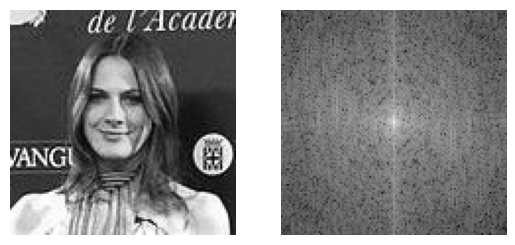

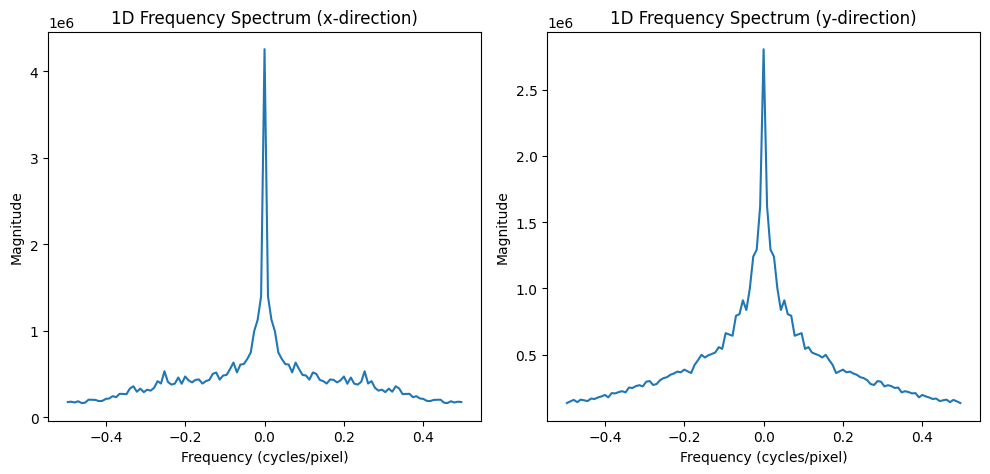

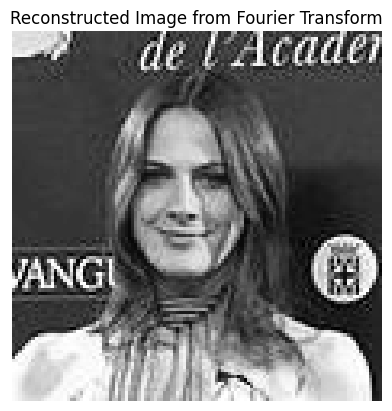

In [24]:
# fourier_synthesis.py

import numpy as np
import matplotlib.pyplot as plt

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    print(ft.shape)
    return np.fft.fftshift(ft)

def reconstruct_image(ft):
    # Swap axes before inverse Fourier transform
    ft = np.fft.ifftshift(ft)
    # Perform inverse Fourier transform
    reconstructed_image = np.fft.ifft2(ft)
    # Swap axes after inverse Fourier transform
    reconstructed_image = np.fft.fftshift(reconstructed_image)
    # Take the real part of the result (since the Fourier transform can have complex values)
    reconstructed_image = np.real(reconstructed_image)
    return reconstructed_image

# Read and process image
image_filename = "/kaggle/working/wiki_crop_all/22533743_1977-11-03_2013.jpg"
image = plt.imread(image_filename)
image = image[:, :, :3].mean(axis=2)  # Convert to grayscale

plt.set_cmap("gray")

ft = calculate_2dft(image)

plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.show()

# Compute the 1D frequency spectra along the x and y directions
freq_x = np.fft.fftshift(np.fft.fftfreq(ft.shape[1]))
freq_y = np.fft.fftshift(np.fft.fftfreq(ft.shape[0]))
spectrum_x = np.abs(ft).sum(axis=0)
spectrum_y = np.abs(ft).sum(axis=1)

# Plot the 1D frequency spectra
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(freq_x, spectrum_x)
plt.title('1D Frequency Spectrum (x-direction)')
plt.xlabel('Frequency (cycles/pixel)')
plt.ylabel('Magnitude')

plt.subplot(1, 2, 2)
plt.plot(freq_y, spectrum_y)
plt.title('1D Frequency Spectrum (y-direction)')
plt.xlabel('Frequency (cycles/pixel)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

# Reconstruct the image from the Fourier transform
reconstructed_image = reconstruct_image(ft)

# Plot the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image from Fourier Transform')
plt.axis('off')  # Turn off axis
plt.show()

(150, 150)
(slice(67, 83, None), slice(67, 83, None))


/tmp/ipykernel_33/2465644293.py:44: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(ft_masked)))


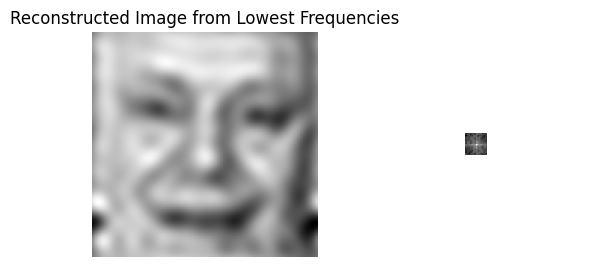

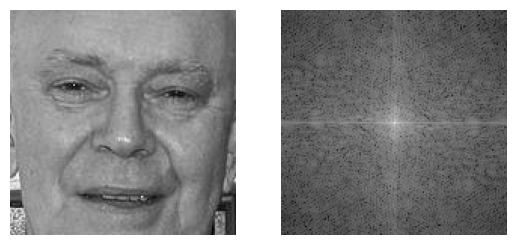

In [78]:
from skimage.transform import resize
def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

# Example input array
# Read and process image
image_filename = "/kaggle/working/wiki_crop_all/1975_1939-04-12_2010.jpg"
image = plt.imread(image_filename)
image = image[80:230, 100:250]
#image = resize(image, (50, 50), anti_aliasing=True)
image = image[:, :, :3].mean(axis=2)  # Convert to grayscale

# Calculate the 2D Fourier transform
ft = calculate_2dft(image)

# Get the shape of the Fourier transform
ft_shape = ft.shape
print(ft_shape)

# Determine the size of the region to select in the center
center_size = (16, 16)  # Adjust this based on your requirements

# Create a mask to select the center region
mask = np.zeros_like(ft, dtype=bool)
center_indices = tuple(slice((dim - size) // 2, (dim + size) // 2) for dim, size in zip(ft_shape, center_size))
mask[center_indices] = True
#mask = ~mask

print(center_indices)

# Apply the mask to the Fourier transform
ft_masked = ft * mask

# Perform inverse Fourier transform to obtain the image
reconstructed_image = reconstruct_image(ft_masked)

plt.subplot(121)
plt.imshow(np.abs(reconstructed_image), cmap='gray')  # Plot the magnitude of the image
plt.title('Reconstructed Image from Lowest Frequencies')
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft_masked)))
plt.axis("off")
plt.show()

plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.show()


/tmp/ipykernel_33/1603240356.py:56: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(ft_masked)))


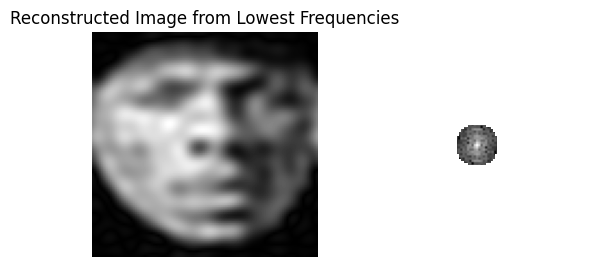

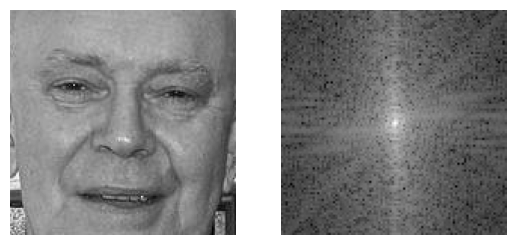

In [90]:
def create_circular_mask(shape, center, radius):
    """
    Create a circular mask.

    Parameters:
    - shape: tuple, shape of the mask (rows, cols)
    - center: tuple, center of the circle (x, y)
    - radius: int, radius of the circle

    Returns:
    - mask: 2D boolean array representing the circular mask
    """
    rows, cols = shape
    x, y = center

    # Create a grid of coordinates
    Y, X = np.ogrid[:rows, :cols]

    # Calculate the distance from each pixel to the center
    distance_from_center = np.sqrt((X - x)**2 + (Y - y)**2)

    # Create the circular mask
    mask = distance_from_center <= radius

    return mask

image_filename = "/kaggle/working/wiki_crop_all/1975_1939-04-12_2010.jpg"
image = plt.imread(image_filename)
image = image[80:230, 100:250]
#image = resize(image, (50, 50), anti_aliasing=True)
image = image[:, :, :3].mean(axis=2)  # Convert to grayscale

# Calculate the 2D Fourier transform
ft = calculate_2dft(image)
# Example shape of the mask (should match the shape of the Fourier transform)
mask_shape = ft.shape

# Example center and radius of the circle
center = (mask_shape[0] // 2, mask_shape[1] // 2)
radius = 10

# Create the circular mask
mask = create_circular_mask(mask_shape, center, radius)

# Apply the mask to the Fourier transform
ft_masked = ft * mask

# Perform inverse Fourier transform to obtain the image
reconstructed_image = reconstruct_image(ft_masked)

plt.subplot(121)
plt.imshow(np.abs(reconstructed_image), cmap='gray')  # Plot the magnitude of the image
plt.title('Reconstructed Image from Lowest Frequencies')
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft_masked)))
plt.axis("off")
plt.show()

plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.show()


(100, 100)


/tmp/ipykernel_33/2962876858.py:70: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(ft_masked)))


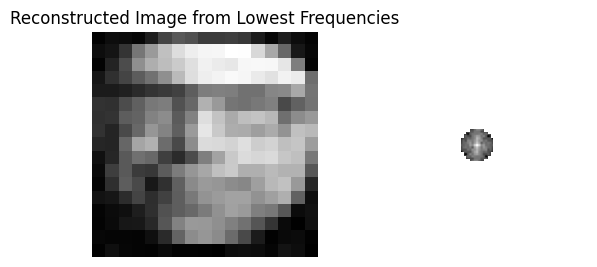

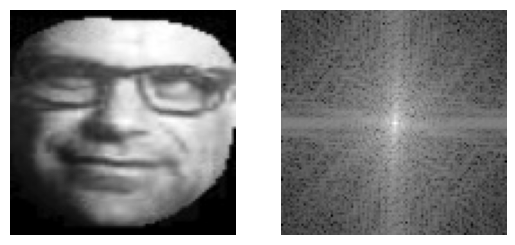

In [119]:
def create_circular_mask(shape, center, radius):
    """
    Create a circular mask.

    Parameters:
    - shape: tuple, shape of the mask (rows, cols)
    - center: tuple, center of the circle (x, y)
    - radius: int, radius of the circle

    Returns:
    - mask: 2D boolean array representing the circular mask
    """
    rows, cols = shape
    x, y = center

    # Create a grid of coordinates
    Y, X = np.ogrid[:rows, :cols]

    # Calculate the distance from each pixel to the center
    distance_from_center = np.sqrt((X - x)**2 + (Y - y)**2)

    # Create the circular mask
    mask = distance_from_center <= radius

    return mask

image_filename = "/kaggle/input/cut-faces-top-9000/norm_cut_faces/18584283_1966-06-03_2012.jpg"
image = plt.imread(image_filename)

# Calculate the 2D Fourier transform
ft = calculate_2dft(image)
# Example shape of the mask (should match the shape of the Fourier transform)
mask_shape = ft.shape

print(mask_shape)

# Example center and radius of the circle
center = (mask_shape[0] // 2, mask_shape[1] // 2)
radius = 8

# Create the circular mask
mask = create_circular_mask(mask_shape, center, radius)

# Apply the mask to the Fourier transform
ft_masked = ft * mask

# Find the indices where ft_masked is non-zero
nonzero_indices = np.nonzero(ft_masked)

# Get the bounding box of the non-zero region
min_row = np.min(nonzero_indices[0])
max_row = np.max(nonzero_indices[0])
min_col = np.min(nonzero_indices[1])
max_col = np.max(nonzero_indices[1])

# Extract the non-zero region from ft_masked
ft_masked_nonzero = ft_masked[min_row:max_row+1, min_col:max_col+1]

# Visualize ft_masked_nonzero or use it for further processing


# Perform inverse Fourier transform to obtain the image
reconstructed_image = reconstruct_image(ft_masked_nonzero)

plt.subplot(121)
plt.imshow(np.abs(reconstructed_image), cmap='gray')  # Plot the magnitude of the image
plt.title('Reconstructed Image from Lowest Frequencies')
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft_masked)))
plt.axis("off")
plt.show()

plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.show()


(100, 100)


/tmp/ipykernel_33/961722731.py:70: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(ft_masked)))


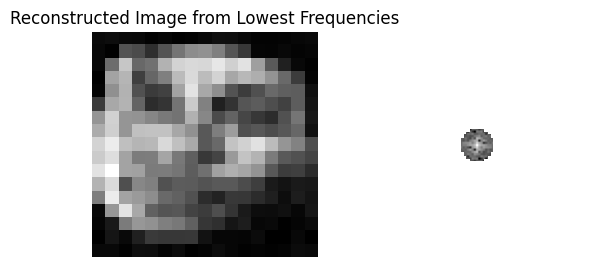

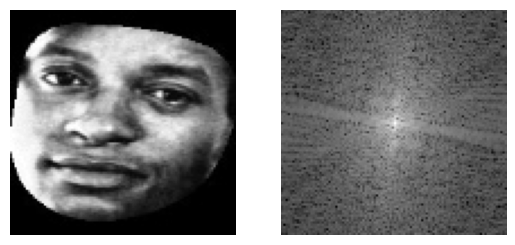

In [120]:
def create_circular_mask(shape, center, radius):
    """
    Create a circular mask.

    Parameters:
    - shape: tuple, shape of the mask (rows, cols)
    - center: tuple, center of the circle (x, y)
    - radius: int, radius of the circle

    Returns:
    - mask: 2D boolean array representing the circular mask
    """
    rows, cols = shape
    x, y = center

    # Create a grid of coordinates
    Y, X = np.ogrid[:rows, :cols]

    # Calculate the distance from each pixel to the center
    distance_from_center = np.sqrt((X - x)**2 + (Y - y)**2)

    # Create the circular mask
    mask = distance_from_center <= radius

    return mask

image_filename = "/kaggle/input/cut-faces-top-9000/norm_cut_faces/10942296_1939-04-22_1966.jpg"
image = plt.imread(image_filename)

# Calculate the 2D Fourier transform
ft = calculate_2dft(image)
# Example shape of the mask (should match the shape of the Fourier transform)
mask_shape = ft.shape

print(mask_shape)

# Example center and radius of the circle
center = (mask_shape[0] // 2, mask_shape[1] // 2)
radius = 8

# Create the circular mask
mask = create_circular_mask(mask_shape, center, radius)

# Apply the mask to the Fourier transform
ft_masked = ft * mask

# Find the indices where ft_masked is non-zero
nonzero_indices = np.nonzero(ft_masked)

# Get the bounding box of the non-zero region
min_row = np.min(nonzero_indices[0])
max_row = np.max(nonzero_indices[0])
min_col = np.min(nonzero_indices[1])
max_col = np.max(nonzero_indices[1])

# Extract the non-zero region from ft_masked
ft_masked_nonzero = ft_masked[min_row:max_row+1, min_col:max_col+1]

# Visualize ft_masked_nonzero or use it for further processing


# Perform inverse Fourier transform to obtain the image
reconstructed_image = reconstruct_image(ft_masked_nonzero)

plt.subplot(121)
plt.imshow(np.abs(reconstructed_image), cmap='gray')  # Plot the magnitude of the image
plt.title('Reconstructed Image from Lowest Frequencies')
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft_masked)))
plt.axis("off")
plt.show()

plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.show()


In [5]:
def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

def create_circular_mask(shape, center, radius):
    """
    Create a circular mask.

    Parameters:
    - shape: tuple, shape of the mask (rows, cols)
    - center: tuple, center of the circle (x, y)
    - radius: int, radius of the circle

    Returns:
    - mask: 2D boolean array representing the circular mask
    """
    rows, cols = shape
    x, y = center

    # Create a grid of coordinates
    Y, X = np.ogrid[:rows, :cols]

    # Calculate the distance from each pixel to the center
    distance_from_center = np.sqrt((X - x)**2 + (Y - y)**2)

    # Create the circular mask
    mask = distance_from_center <= radius

    return mask


files = os.listdir('/kaggle/input/cut-faces-top-9000/norm_cut_faces')
masked_ft_df = []

for image_filename in tqdm(files, unit='image', desc='Processing images...'):
    image = plt.imread("/kaggle/input/cut-faces-top-9000/norm_cut_faces/" + image_filename)
    

    # Calculate the 2D Fourier transform
    ft = calculate_2dft(image)
    # Example shape of the mask (should match the shape of the Fourier transform)
    mask_shape = ft.shape

    # Example center and radius of the circle
    center = (mask_shape[0] // 2, mask_shape[1] // 2)
    radius = 8

    # Create the circular mask
    mask = create_circular_mask(mask_shape, center, radius)

    # Apply the mask to the Fourier transform
    ft_masked = ft * mask
    
    # Find the indices where ft_masked is non-zero
    nonzero_indices = np.nonzero(ft_masked)

    # Get the bounding box of the non-zero region
    min_row = np.min(nonzero_indices[0])
    max_row = np.max(nonzero_indices[0])
    min_col = np.min(nonzero_indices[1])
    max_col = np.max(nonzero_indices[1])

    # Extract the non-zero region from ft_masked
    ft_masked_nonzero = ft_masked[min_row:max_row+1, min_col:max_col+1]
    
    masked_ft_df.append({'image_name': image_filename, 'ft': ft_masked_nonzero})

Processing images...: 100%|██████████| 9000/9000 [00:41<00:00, 214.73image/s]


In [6]:
masked_ft_df = pd.DataFrame(masked_ft_df)
masked_ft_df

image_name  \
0     18584283_1966-06-03_2012.jpg   
1     10942296_1939-04-22_1966.jpg   
2     12646504_1969-01-05_2000.jpg   
3     18786524_1988-05-09_2010.jpg   
4      7421180_1944-08-19_1966.jpg   
...                            ...   
8995  46679567_1961-07-02_2014.jpg   
8996  10565937_1931-05-29_2007.jpg   
8997    382789_1951-11-29_2009.jpg   
8998   5577992_1975-11-01_2010.jpg   
8999   4454054_1939-07-14_1980.jpg   

                                                     ft  
0     [[0j, -0j, 0j, 0j, 0j, 0j, 0j, -0j, (3388.0339...  
1     [[0j, -0j, 0j, (-0+0j), -0j, 0j, 0j, 0j, (4787...  
2     [[(-0+0j), (-0+0j), -0j, -0j, 0j, 0j, 0j, 0j, ...  
3     [[0j, -0j, 0j, 0j, -0j, 0j, 0j, 0j, (-16373.03...  
4     [[(-0+0j), -0j, 0j, 0j, 0j, 0j, 0j, 0j, (10838...  
...                                                 ...  
8995  [[0j, 0j, -0j, -0j, (-0+0j), (-0+0j), (-0+0j),...  
8996  [[0j, -0j, 0j, 0j, 0j, 0j, 0j, 0j, (30865.1935...  
8997  [[0j, 0j, 0j, 0j, 0j, -0j, 0j, 0j, (13161.7625...  
8998  [[(-0+0j), 0j, 0j, 0j, 0j, (-0+0j), 0j, 0j, (1...  
8999  [[-0j, -0j, 0j, -0j, (-0+0j), 0j, 0j, 0j, (302...  

[9000 rows x 2 columns]

In [110]:
masked_ft_df.to_csv('masked_ft.csv', index=False)

In [118]:
masked_ft_df

image_name  \
0     18584283_1966-06-03_2012.jpg   
1     10942296_1939-04-22_1966.jpg   
2     12646504_1969-01-05_2000.jpg   
3     18786524_1988-05-09_2010.jpg   
4      7421180_1944-08-19_1966.jpg   
...                            ...   
8995  46679567_1961-07-02_2014.jpg   
8996  10565937_1931-05-29_2007.jpg   
8997    382789_1951-11-29_2009.jpg   
8998   5577992_1975-11-01_2010.jpg   
8999   4454054_1939-07-14_1980.jpg   

                                                     ft  
0     [[0j, -0j, 0j, 0j, 0j, 0j, 0j, -0j, (3388.0339...  
1     [[0j, -0j, 0j, (-0+0j), -0j, 0j, 0j, 0j, (4787...  
2     [[(-0+0j), (-0+0j), -0j, -0j, 0j, 0j, 0j, 0j, ...  
3     [[0j, -0j, 0j, 0j, -0j, 0j, 0j, 0j, (-16373.03...  
4     [[(-0+0j), -0j, 0j, 0j, 0j, 0j, 0j, 0j, (10838...  
...                                                 ...  
8995  [[0j, 0j, -0j, -0j, (-0+0j), (-0+0j), (-0+0j),...  
8996  [[0j, -0j, 0j, 0j, 0j, 0j, 0j, 0j, (30865.1935...  
8997  [[0j, 0j, 0j, 0j, 0j, -0j, 0j, 0j, (13161.7625...  
8998  [[(-0+0j), 0j, 0j, 0j, 0j, (-0+0j), 0j, 0j, (1...  
8999  [[-0j, -0j, 0j, -0j, (-0+0j), 0j, 0j, 0j, (302...  

[9000 rows x 2 columns]

Mean Squared Error of magnitudes: 18413835.628836345
Normalized Cross-Correlation of magnitudes: 0.9489885851509909


/tmp/ipykernel_33/1895135467.py:15: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(ft1)), cmap="gray")
/tmp/ipykernel_33/1895135467.py:18: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(ft2)), cmap="gray")


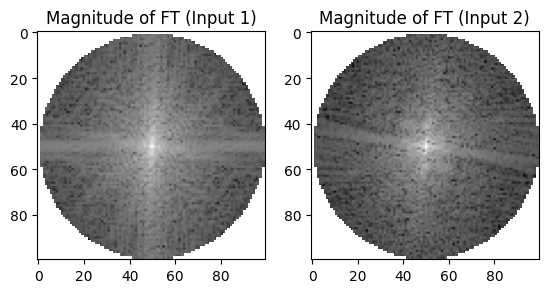

/tmp/ipykernel_33/1895135467.py:22: RuntimeWarning: divide by zero encountered in log
  plt.imshow((np.log(np.abs(ft1))-np.log(np.abs(ft2)))/np.log(np.abs(ft1)), cmap="gray")
/tmp/ipykernel_33/1895135467.py:22: RuntimeWarning: invalid value encountered in subtract
  plt.imshow((np.log(np.abs(ft1))-np.log(np.abs(ft2)))/np.log(np.abs(ft1)), cmap="gray")


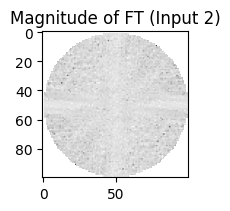

Text(0, 0.5, 'Magnitude')

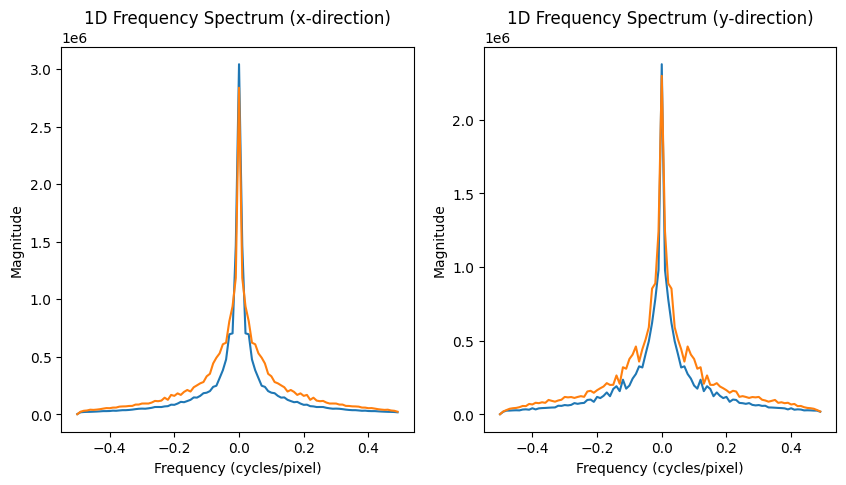

In [164]:
# Option 1: Mean Squared Error (MSE) of magnitudes
ft1 = masked_ft_df1["ft"][0]
ft2 = masked_ft_df1["ft"][1]
mse = np.mean(np.square(np.abs(ft1) - np.abs(ft2)))
print("Mean Squared Error of magnitudes:", mse)

# Option 2: Normalized Cross-Correlation (NCC) of magnitudes
ncc = np.corrcoef(np.abs(ft1.flatten()), np.abs(ft2.flatten()))[0, 1]
print("Normalized Cross-Correlation of magnitudes:", ncc)

# Option 3: Visual comparison (plot the magnitudes)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(np.log(abs(ft1)), cmap="gray")
plt.title("Magnitude of FT (Input 1)")
plt.subplot(132)
plt.imshow(np.log(abs(ft2)), cmap="gray")
plt.title("Magnitude of FT (Input 2)")
plt.show()
plt.subplot(133)
plt.imshow((np.log(np.abs(ft1))-np.log(np.abs(ft2)))/np.log(np.abs(ft1)), cmap="gray")
plt.title("Magnitude of FT (Input 2)")
plt.show()

freq_x1 = np.fft.fftshift(np.fft.fftfreq(ft1.shape[1]))
freq_y1 = np.fft.fftshift(np.fft.fftfreq(ft1.shape[0]))
spectrum_x1 = np.abs(ft1).sum(axis=0)
spectrum_y1 = np.abs(ft1).sum(axis=1)

freq_x2 = np.fft.fftshift(np.fft.fftfreq(ft2.shape[1]))
freq_y2 = np.fft.fftshift(np.fft.fftfreq(ft2.shape[0]))
spectrum_x2 = np.abs(ft2).sum(axis=0)
spectrum_y2 = np.abs(ft2).sum(axis=1)


# Plot the 1D frequency spectra
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(freq_x1, spectrum_x1)
plt.plot(freq_x2, spectrum_x2)
plt.title('1D Frequency Spectrum (x-direction)')
plt.xlabel('Frequency (cycles/pixel)')
plt.ylabel('Magnitude')

plt.subplot(1, 2, 2)
plt.plot(freq_y1, spectrum_y1)
plt.plot(freq_y2, spectrum_y2)
plt.title('1D Frequency Spectrum (y-direction)')
plt.xlabel('Frequency (cycles/pixel)')
plt.ylabel('Magnitude')

Processing cluster...:   0%|          | 0/20 [00:00<?, ?cluster/s]/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Processing cluster...:   5%|▌         | 1/20 [00:01<00:20,  1.09s/cluster]/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Processing cluster...:  10%|█         | 2/20 [00:03<00:34,  1.90s/cluster]/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Processing cluster...:  15%|█▌        | 3/20 [00:06<00:38,  2.25s/cluster]/opt/conda/li

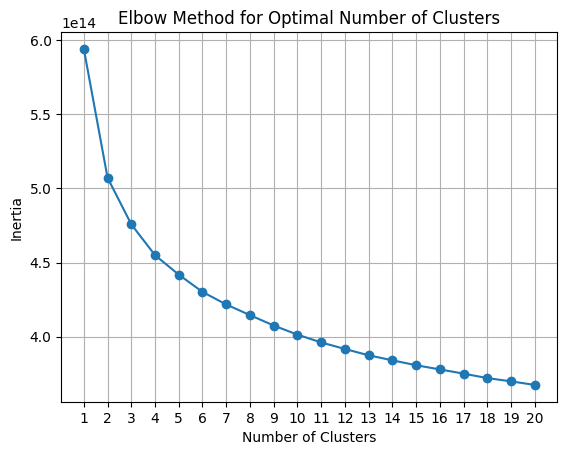

In [168]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing image_name and ft columns

# Extract magnitudes and flatten the arrays
data = []
for ft_array in tqdm(masked_ft_df['ft'], unit='tf', desc='Processing tf...'):
    magnitudes = np.abs(ft_array)
    flattened_array = magnitudes.flatten()
    data.append(flattened_array)

# Convert the list of arrays into a 2D feature matrix
feature_matrix = np.array(data)

# Define a range of cluster numbers to test
cluster_range = range(1, 21)  # Test clusters from 1 to 10

# Calculate the inertia (within-cluster sum of squares) for each cluster number
inertia = []
for n_clusters in tqdm(cluster_range, unit='cluster', desc='Processing cluster...'):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(feature_matrix)
    inertia.append(kmeans.inertia_)

# Plot the inertia values against the number of clusters
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()


In [22]:
kmeans = KMeans(n_clusters=7)  # Choose the number of clusters as needed
kmeans.fit(feature_matrix)

# Assign cluster labels to each image
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
masked_ft_df['cluster_label'] = cluster_labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
masked_ft_df.to_csv('masked_ft_clustered.csv', index=False)

In [25]:
masked_ft_df

image_name  \
0     18584283_1966-06-03_2012.jpg   
1     10942296_1939-04-22_1966.jpg   
2     12646504_1969-01-05_2000.jpg   
3     18786524_1988-05-09_2010.jpg   
4      7421180_1944-08-19_1966.jpg   
...                            ...   
8995  46679567_1961-07-02_2014.jpg   
8996  10565937_1931-05-29_2007.jpg   
8997    382789_1951-11-29_2009.jpg   
8998   5577992_1975-11-01_2010.jpg   
8999   4454054_1939-07-14_1980.jpg   

                                                     ft  cluster_label  
0     [[0j, -0j, 0j, 0j, 0j, 0j, 0j, -0j, (3388.0339...              0  
1     [[0j, -0j, 0j, (-0+0j), -0j, 0j, 0j, 0j, (4787...              1  
2     [[(-0+0j), (-0+0j), -0j, -0j, 0j, 0j, 0j, 0j, ...              0  
3     [[0j, -0j, 0j, 0j, -0j, 0j, 0j, 0j, (-16373.03...              3  
4     [[(-0+0j), -0j, 0j, 0j, 0j, 0j, 0j, 0j, (10838...              3  
...                                                 ...            ...  
8995  [[0j, 0j, -0j, -0j, (-0+0j), (-0+0j), (-0+0j),...              2  
8996  [[0j, -0j, 0j, 0j, 0j, 0j, 0j, 0j, (30865.1935...              2  
8997  [[0j, 0j, 0j, 0j, 0j, -0j, 0j, 0j, (13161.7625...              4  
8998  [[(-0+0j), 0j, 0j, 0j, 0j, (-0+0j), 0j, 0j, (1...              4  
8999  [[-0j, -0j, 0j, -0j, (-0+0j), 0j, 0j, 0j, (302...              0  

[9000 rows x 3 columns]

In [26]:


# Assuming df contains the DataFrame with image_name, ft, and cluster_label columns

# Convert the 'ft' column to a numpy array
masked_ft_df['ft'] = masked_ft_df['ft'].apply(np.array)

# Group the DataFrame by cluster_label and calculate the mean of the 'ft' column for each group
average_ft_per_cluster = masked_ft_df.groupby('cluster_label')['ft'].apply(np.mean)


def calculate_ncc(ft1, ft2):
    # Calculate the NCC between two Fourier transforms
    ncc = np.corrcoef(np.abs(ft1.flatten()), np.abs(ft2.flatten()))[0, 1]
    return ncc

# Iterate through cluster items and find the top 3 images closest to the average
top_images = []

for cluster_label, average_ft in average_ft_per_cluster.items():
    cluster_df = masked_ft_df[masked_ft_df['cluster_label'] == cluster_label]
    distances = []

    # Calculate NCC for each image in the cluster
    for ft in cluster_df['ft']:
        ncc = calculate_ncc(np.abs(ft), np.abs(average_ft))
        distances.append(ncc)

    # Get the indices of the top 3 images with the highest NCC values
    top_indices = np.argsort(distances)[-5:]

    # Get the image names corresponding to the top indices
    top_image_names = cluster_df.iloc[top_indices]['image_name'].tolist()

    # Append the top image names to the list
    top_images.extend(top_image_names)




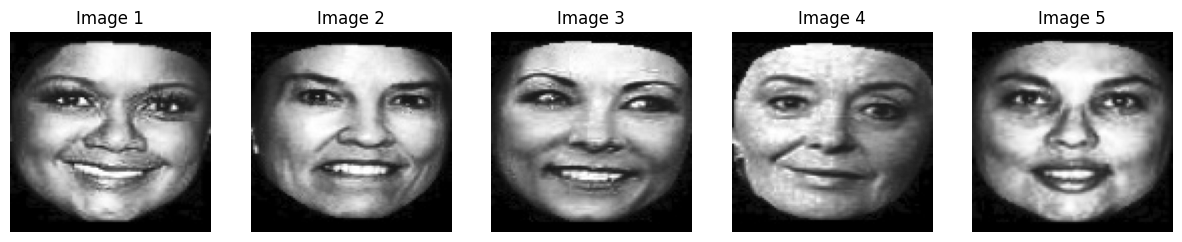

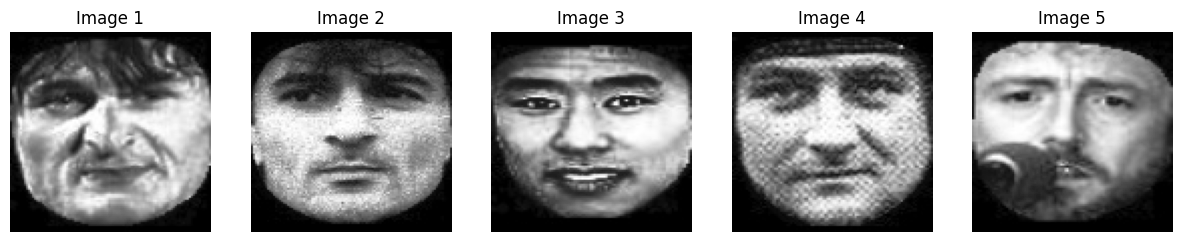

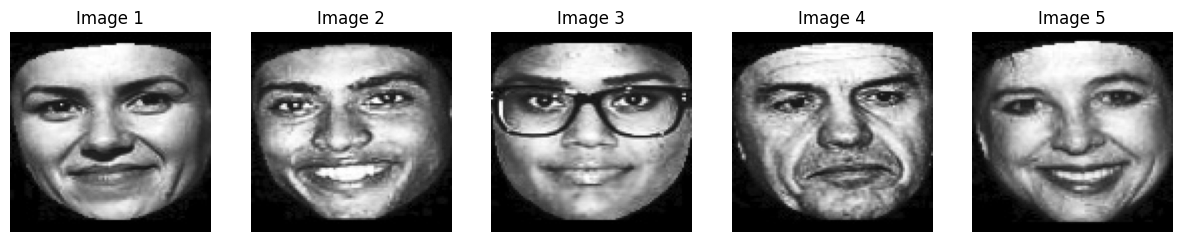

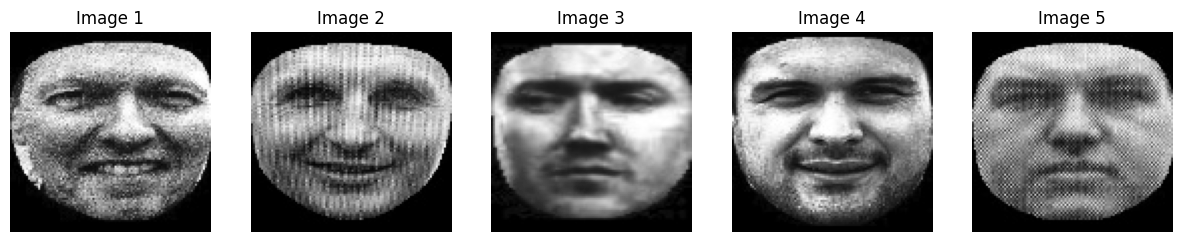

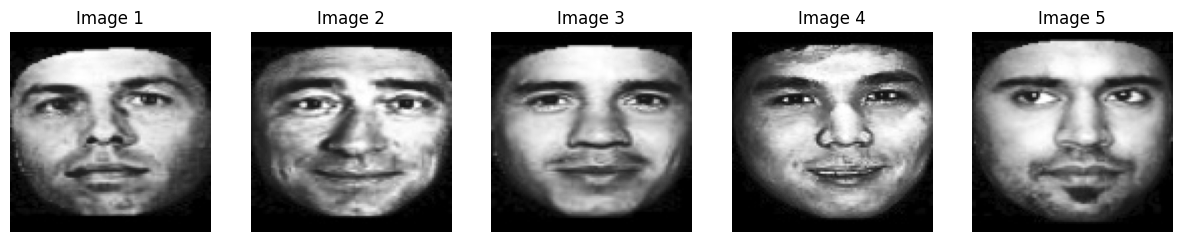

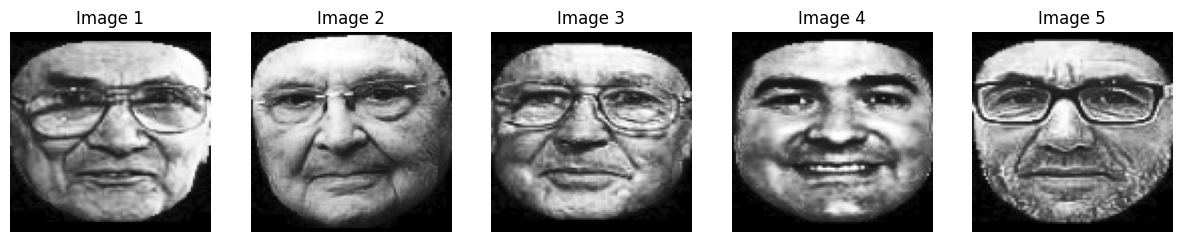

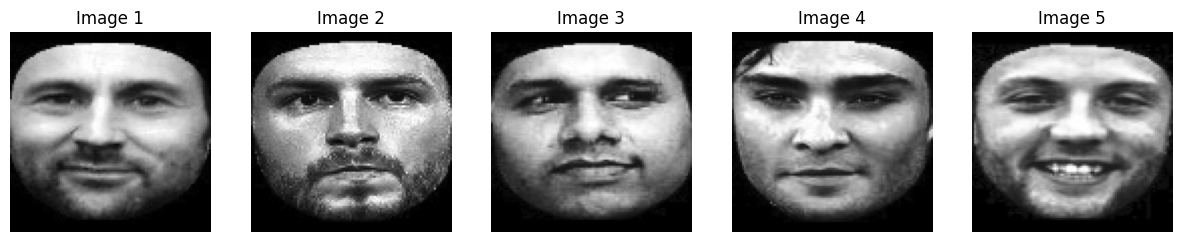

In [27]:
import matplotlib.pyplot as plt

# Define the number of clusters
num_clusters = len(top_images) // 5

# Iterate through clusters and display top 3 images for each cluster
for i in range(num_clusters):
    cluster_images = top_images[i * 5: (i + 1) * 5]
    plt.figure(figsize=(15, 5))
    plt.set_cmap("gray")
    
    # Iterate through images in the cluster
    for j, image_name in enumerate(cluster_images, start=1):
        image_filename = "/kaggle/input/cut-faces-top-9000/norm_cut_faces/" + image_name
        image = plt.imread(image_filename)
        
        # Plot the image in the corresponding subplot
        plt.subplot(1, 5, j)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image {j}")
    
    plt.show()

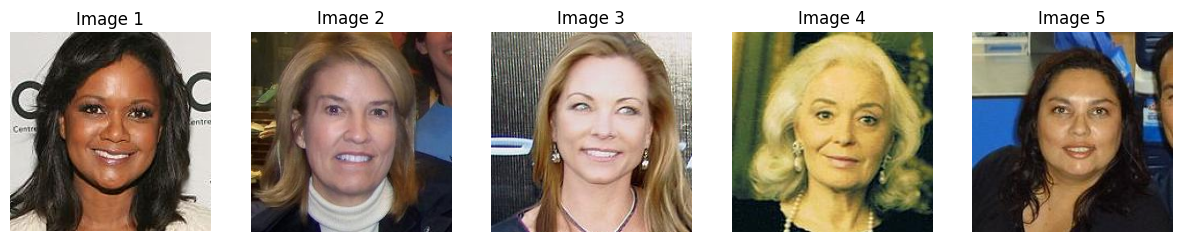

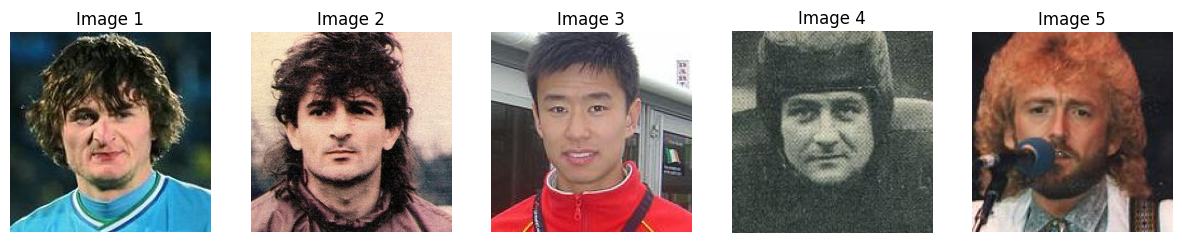

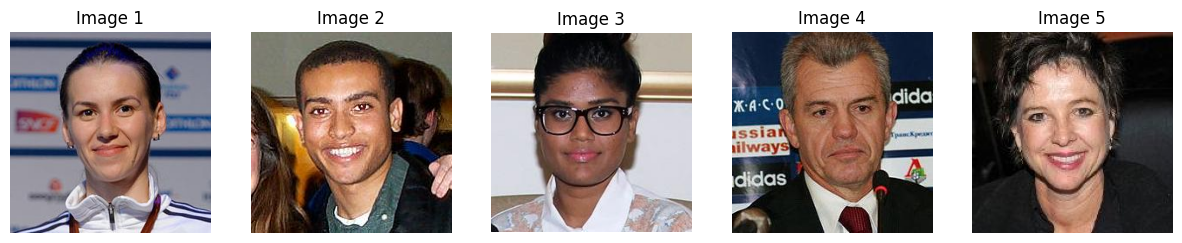

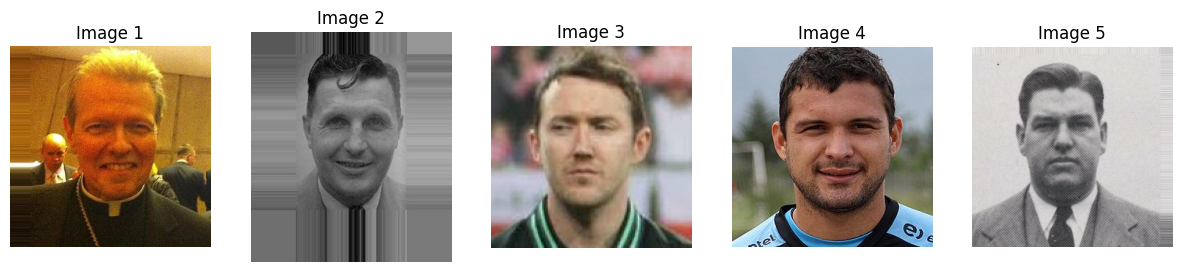

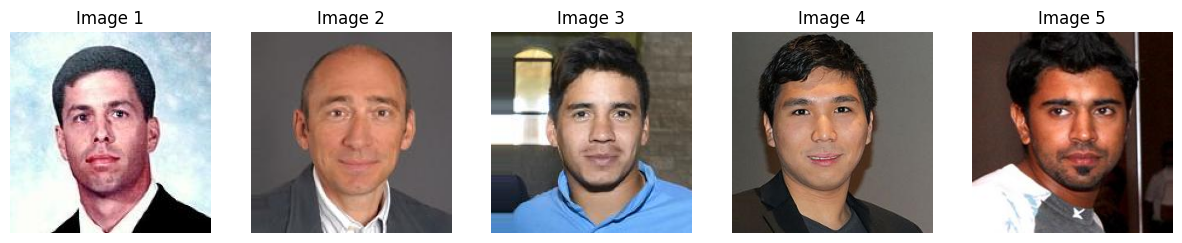

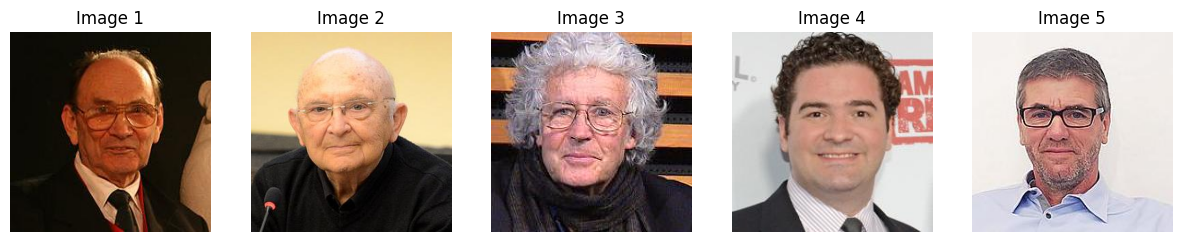

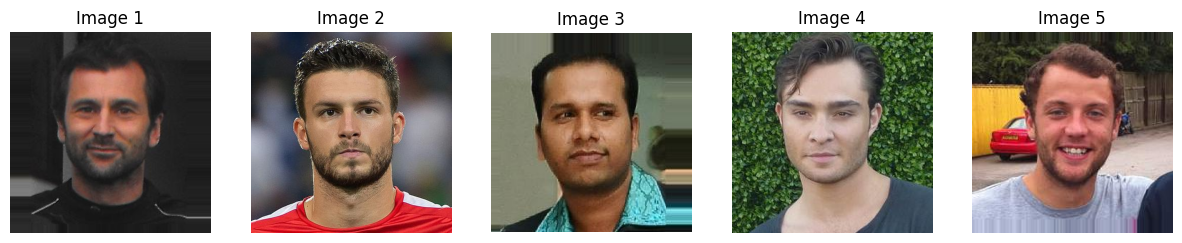

In [29]:
import matplotlib.pyplot as plt

# Define the number of clusters
num_clusters = len(top_images) // 5

# Iterate through clusters and display top 3 images for each cluster
for i in range(num_clusters):
    cluster_images = top_images[i * 5: (i + 1) * 5]
    plt.figure(figsize=(15, 5))
    #plt.set_cmap("gray")
    
    # Iterate through images in the cluster
    for j, image_name in enumerate(cluster_images, start=1):
        image_filename = "/kaggle/working/wiki_crop_all/" + image_name
        image = plt.imread(image_filename)
        
        # Plot the image in the corresponding subplot
        plt.subplot(1, 5, j)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image {j}")
    
    plt.show()

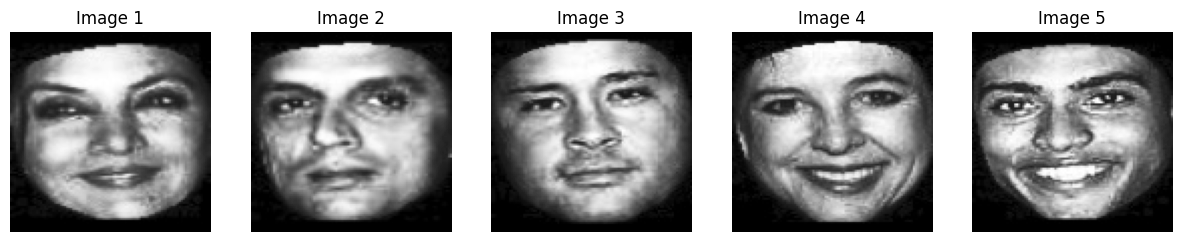

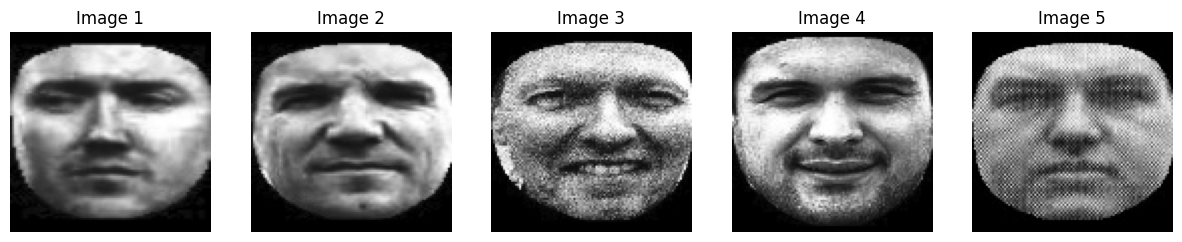

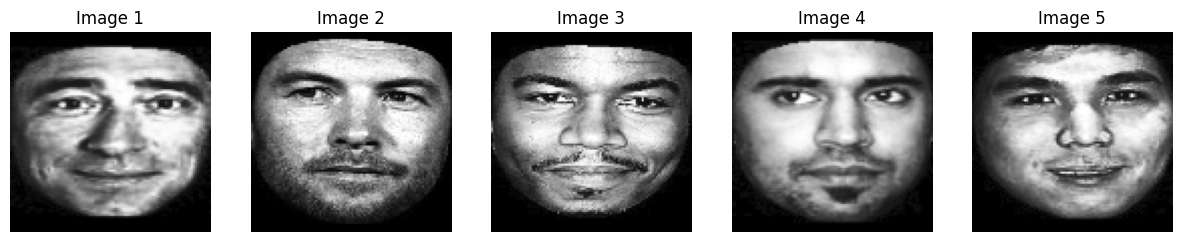

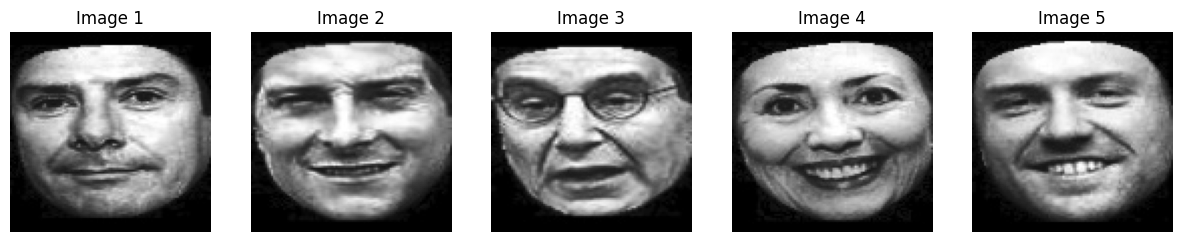

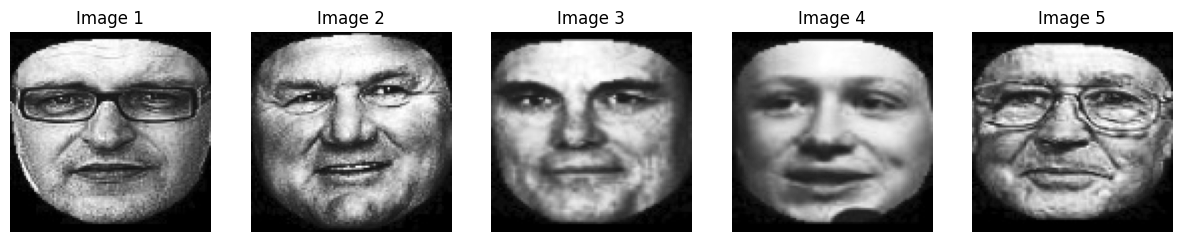

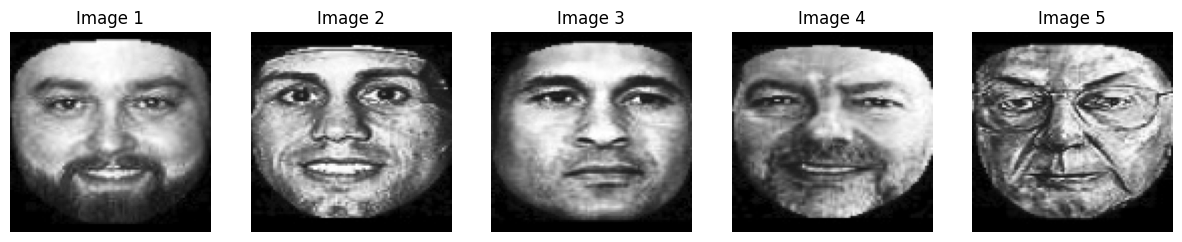

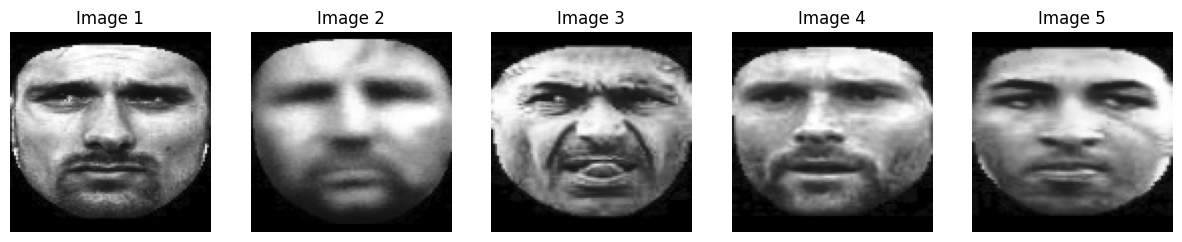

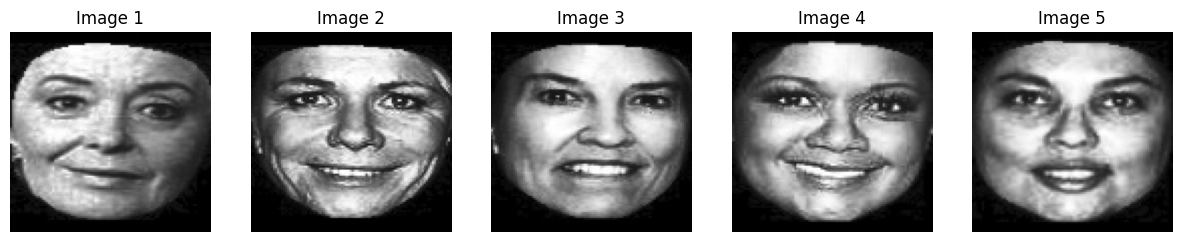

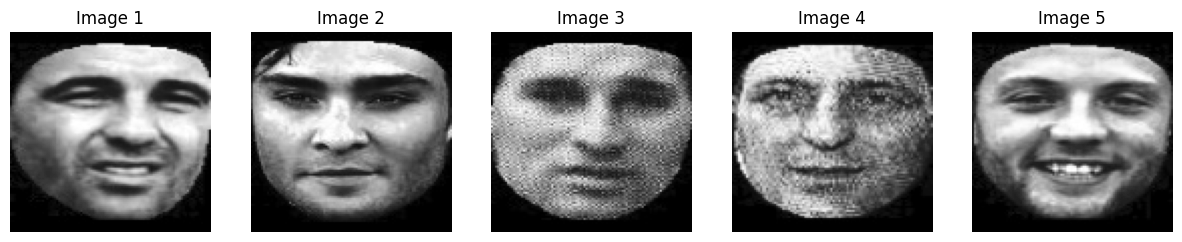

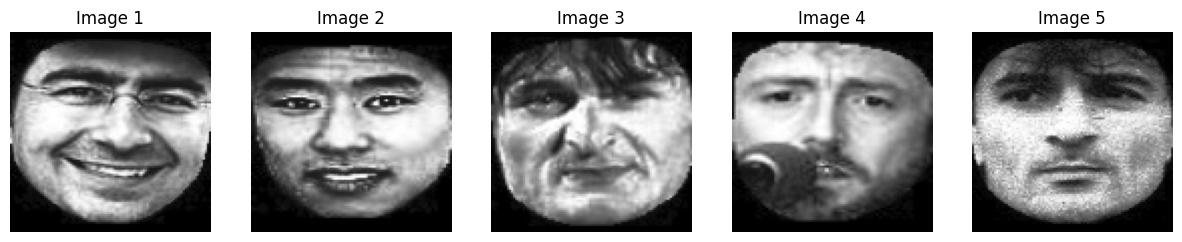

In [17]:
import matplotlib.pyplot as plt

# Define the number of clusters
num_clusters = len(top_images) // 5

# Iterate through clusters and display top 3 images for each cluster
for i in range(num_clusters):
    cluster_images = top_images[i * 5: (i + 1) * 5]
    plt.figure(figsize=(15, 5))
    plt.set_cmap("gray")

    # Iterate through images in the cluster
    for j, image_name in enumerate(cluster_images, start=1):
        image_filename = "/kaggle/input/cut-faces-top-9000/norm_cut_faces/" + image_name
        image = plt.imread(image_filename)

        # Plot the image in the corresponding subplot
        plt.subplot(1, 5, j)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image {j}")

    plt.show()


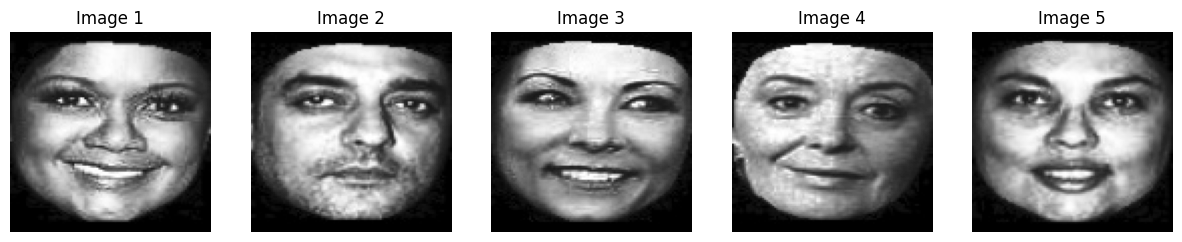

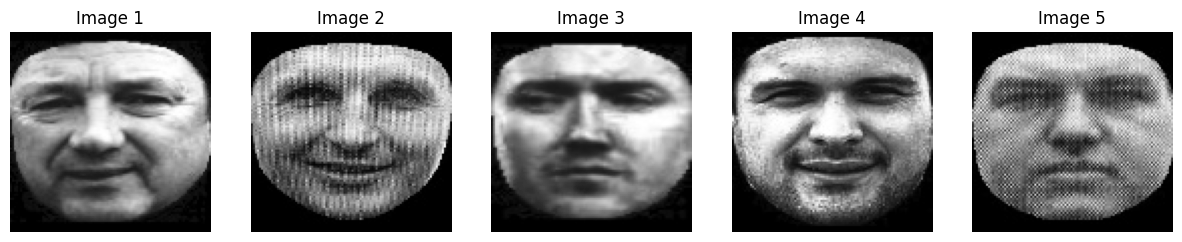

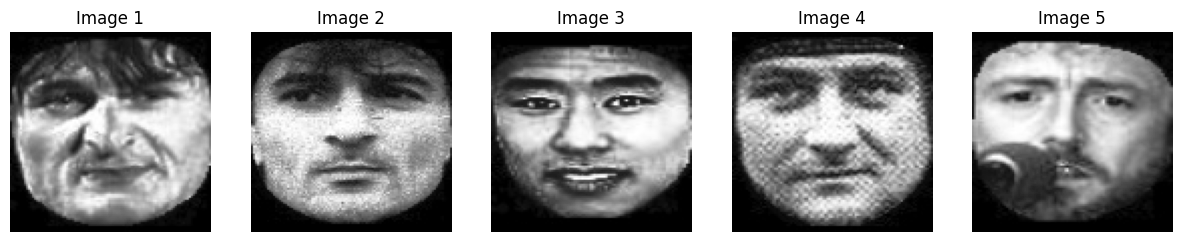

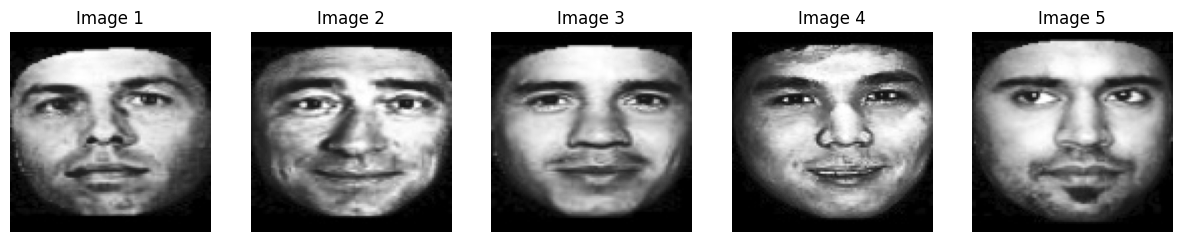

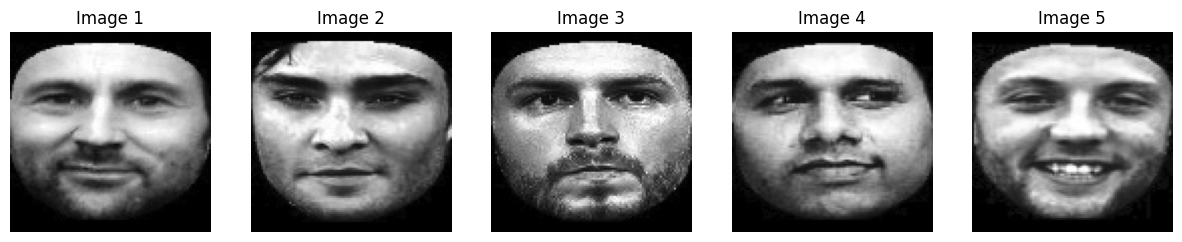

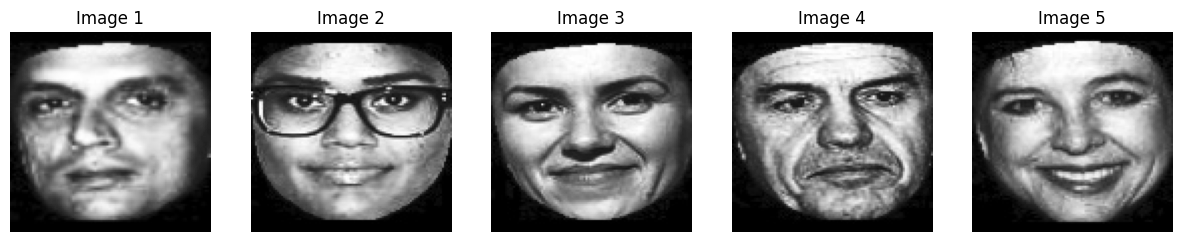

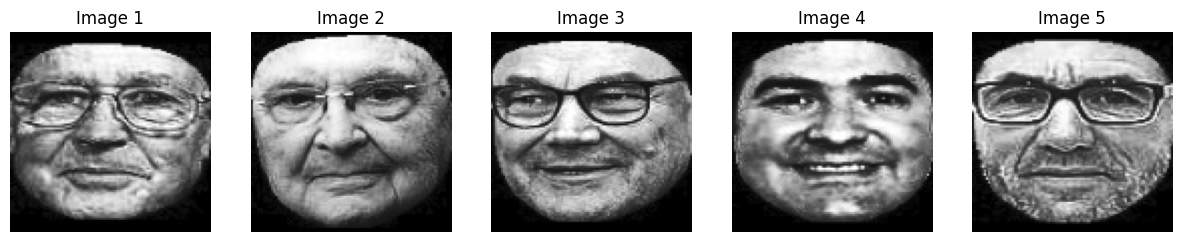

In [13]:
import matplotlib.pyplot as plt

# Define the number of clusters
num_clusters = len(top_images) // 5

# Iterate through clusters and display top 3 images for each cluster
for i in range(num_clusters):
    cluster_images = top_images[i * 5: (i + 1) * 5]
    plt.figure(figsize=(15, 5))
    plt.set_cmap("gray")
    
    # Iterate through images in the cluster
    for j, image_name in enumerate(cluster_images, start=1):
        image_filename = "/kaggle/input/cut-faces-top-9000/norm_cut_faces/" + image_name
        image = plt.imread(image_filename)
        
        # Plot the image in the corresponding subplot
        plt.subplot(1, 5, j)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image {j}")
    
    plt.show()
